In [19]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import itertools
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [20]:
data_path = '/kaggle/input/groceries/groceries.csv'
df = pd.read_csv(data_path, names=['products'], header=None, skiprows=1)
df

,products
0,"citrus fruit,semi-finished bread,margarine,rea..."
1,"tropical fruit,yogurt,coffee"
2,whole milk
3,"pip fruit,yogurt,cream cheese ,meat spreads"
4,"other vegetables,whole milk,condensed milk,lon..."
...,...
695,"pork,UHT-milk,bottled water,soda,canned beer"
696,"other vegetables,curd,yogurt,curd cheese,marga..."
697,"rolls/buns,soda,fruit/vegetable juice,canned b..."
698,"frankfurter,pip fruit,whole milk,rolls/buns,ro..."


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   products  700 non-null    object
dtypes: object(1)
memory usage: 5.6+ KB


In [22]:
import pandas as pd

def load_data_set(filename):
    # Importing dataset, treating all columns as strings
    data = pd.read_csv(filename, header=None, dtype='str', skiprows=1)
    n_of_transactions = data.shape[0]
    # Converting DataFrame into a list of lists for Apriori algorithm
    records = []
    for i in range(n_of_transactions):
        items = data.iloc[i][0].split(',')
        # Filtering empty items
        transaction = [item.strip() for item in items if item]
        if transaction:
            records.append(transaction)
    return records

def Create_C1(data_set):
    C1 = set()
    for t in data_set:
        for item in t:
            item_set = frozenset([item])
            C1.add(item_set)
    return C1

def is_apriori(Ck_item, Lk_sub_1):
    for item in Ck_item:
        sub_item = Ck_item - frozenset([item])
        if sub_item not in Lk_sub_1:
            return False
    return True

def Create_Ck(Lk_sub_1, k):
    Ck = set()
    list_Lk_sub_1 = list(Lk_sub_1)
    for i in range(len(list_Lk_sub_1)):
        for j in range(i + 1, len(list_Lk_sub_1)):
            l1 = list(list_Lk_sub_1[i])
            l2 = list(list_Lk_sub_1[j])
            l1.sort()
            l2.sort()
            if l1[:k - 2] == l2[:k - 2]:
                Ck_item = list_Lk_sub_1[i] | list_Lk_sub_1[j]
                if is_apriori(Ck_item, Lk_sub_1):
                    Ck.add(Ck_item)
    return Ck

def Generate_Lk_By_Ck(data_set, Ck, minsup, support_data):
    Lk = set()
    item_count = {}
    for t in data_set:
        for Ck_item in Ck:
            if Ck_item.issubset(t):
                item_count[Ck_item] = item_count.get(Ck_item, 0) + 1
    data_num = float(len(data_set))
    for item in item_count:
        if (item_count[item] / data_num) >= minsup:
            Lk.add(item)
            support_data[item] = item_count[item] / data_num
    return Lk

def Generate_L(data_set, minsup, max_k=10):
    support_data = {}
    C1 = Create_C1(data_set)
    L1 = Generate_Lk_By_Ck(data_set, C1, minsup, support_data)
    L = [L1]
    Lk_sub_1 = L1.copy()
    for k in range(2, max_k + 1):
        Ck = Create_Ck(Lk_sub_1, k)
        Lk = Generate_Lk_By_Ck(data_set, Ck, minsup, support_data)
        if not Lk:
            break
        L.append(Lk)
        Lk_sub_1 = Lk
    return L, support_data

def Generate_Rule(L, support_data, minconf, minlift):
    rule_list = []
    sub_set_list = []
    
    # Calculate the total support for ease of use
    total_support = sum(support_data.values())

    for i in range(len(L)):
        for frequent_set in L[i]:
            for sub_set in sub_set_list:
                if sub_set.issubset(frequent_set):
                    # Calculate lift, conf, leverage, and conviction
                    support = support_data[frequent_set]
                    conf = support / support_data[sub_set]
                    lift = conf / support_data[frequent_set - sub_set]

                    # Calculate leverage
                    p_xy = support  # P(X ∩ Y)
                    p_x = support_data[sub_set]  # P(X)
                    p_y = support_data[frequent_set - sub_set]  # P(Y)
                    leverage = p_xy - (p_x * p_y)

                    # Calculate conviction
                    p_not_y = 1 - p_y  # P(not Y)
                    conviction = (1 - p_y) / (1 - conf) if conf < 1 else float('inf')

                    rule = [sub_set, frequent_set - sub_set, round(lift, 2), round(conf, 2), round(leverage, 2), round(conviction, 2), round(support, 2)]
                    if (minlift == 'NULL' and conf >= minconf and rule not in rule_list) or (conf >= minconf and rule not in rule_list and lift >= minlift):
                        rule_list.append(rule)
            sub_set_list.append(frequent_set)
    return rule_list

In [23]:
def plot_top_frequent_itemsets(support_data, top_n=10):
    # Convert support_data to a DataFrame
    itemsets = pd.DataFrame(list(support_data.items()), columns=['Itemset', 'Support'])
    
    # Sort the itemsets by support and get the top N
    top_itemsets = itemsets.nlargest(top_n, 'Support')

    # Create a bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_itemsets['Itemset'].astype(str), y=top_itemsets['Support'], palette='viridis')
    plt.title(f'Top-{top_n} Frequent Itemsets')
    plt.xlabel('Itemsets')
    plt.ylabel('Support')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_top_strongest_rules(rule_list, top_n=10):
    # Convert rule list to DataFrame
    rules_df = pd.DataFrame(rule_list, columns=['Freq', 'Conseq', 'Lift', 'Confidence', 'Support'])

    # Sort rules by lift and get the top N
    top_rules = rules_df.nlargest(top_n, 'Lift')

    # Create a scatter plot for Confidence vs. Lift
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=top_rules, x='Lift', y='Confidence', size='Support', sizes=(40, 300), hue='Lift', palette='plasma', legend=None)
    for i in range(top_rules.shape[0]):
        plt.text(top_rules['Lift'].iloc[i], top_rules['Confidence'].iloc[i], str(top_rules['Freq'].iloc[i]), 
                 horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.title(f'Top-{top_n} Strongest Rules by Lift')
    plt.xlabel('Lift')
    plt.ylabel('Confidence')
    plt.tight_layout()
    plt.show()

def plot_top_strongest_rules_with_leverage(rule_list, top_n=10):
    # Convert rule list to DataFrame
    rules_df = pd.DataFrame(rule_list, columns=['Freq', 'Conseq', 'Lift', 'Confidence', 'Leverage', 'Conviction', 'Support'])

    # Sort rules by Lift and get the top N
    top_rules = rules_df.nlargest(top_n, 'Lift')

    # Create a scatter plot for Confidence vs. Lift
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=top_rules, x='Lift', y='Confidence', size='Support', sizes=(40, 300), hue='Leverage', palette='viridis', legend=None)
    
    for i in range(top_rules.shape[0]):
        plt.text(top_rules['Lift'].iloc[i], top_rules['Confidence'].iloc[i], str(top_rules['Freq'].iloc[i]), 
                 horizontalalignment='left', size='medium', color='black', weight='semibold')
    
    plt.title(f'Top-{top_n} Strongest Rules by Lift with Leverage')
    plt.xlabel('Lift')
    plt.ylabel('Confidence')
    plt.tight_layout()
    plt.show()

def generate_report(support_data, rule_list):
    # Create a summary of frequent itemsets
    itemsets_summary = pd.DataFrame(list(support_data.items()), columns=['Itemset', 'Support']).sort_values(by='Support', ascending=False)

    # Create a summary of rules
    rules_df = pd.DataFrame(rule_list, columns=['Freq', 'Conseq', 'Lift', 'Confidence', 'Leverage', 'Conviction', 'Support']).sort_values(by='Lift', ascending=False)

    # Print summaries
    print("### Frequent Itemsets Summary ###")
    print(itemsets_summary.head(10))  # Display top 10 frequent itemsets

    print("\n### Association Rules Summary ###")
    print(rules_df.head(10))  # Display top 10 rules sorted by lift

    # Save summaries to CSV files if needed
    itemsets_summary.to_csv('frequent_itemsets_summary.csv', index=False)
    rules_df.to_csv('association_rules_summary.csv', index=False)

    print("\nReports saved as CSV files.")

In [24]:
def run(minsup, minconf, minlift, filename, top_n=10):
    data_set = load_data_set(filename)
    L, support_data = Generate_L(data_set, minsup)
    rule_list = Generate_Rule(L, support_data, minconf, minlift)

    df = pd.DataFrame(rule_list, columns=['Freq', 'Conseq', 'Lift', 'Confidence', 'Leverage', 'Conviction', 'Support'])
    df['Num_items'] = df.apply(lambda row: len(row.Freq) + len(row.Conseq), axis=1)
    sorted_df = df.sort_values(['Num_items', 'Lift', 'Confidence', 'Support'], 
                                ascending=[True, False, False, False]).reset_index(drop=True)

    return sorted_df, support_data, rule_list

In [25]:
sorted_df, support_data, rule_list = run(minsup = 0.04, minconf = 0.15, minlift = 1.0, filename = data_path)
sorted_df

,Freq,Conseq,Lift,Confidence,Leverage,Conviction,Support,Num_items
0,(root vegetables),(other vegetables),2.29,0.42,0.02,1.41,0.04,2
1,(other vegetables),(root vegetables),2.29,0.23,0.02,1.17,0.04,2
2,(sausage),(rolls/buns),2.25,0.49,0.02,1.54,0.04,2
3,(rolls/buns),(sausage),2.25,0.18,0.02,1.12,0.04,2
4,(root vegetables),(whole milk),1.74,0.44,0.02,1.33,0.04,2
5,(whole milk),(root vegetables),1.74,0.18,0.02,1.09,0.04,2
6,(yogurt),(whole milk),1.52,0.38,0.02,1.21,0.04,2
7,(whole milk),(yogurt),1.52,0.18,0.02,1.07,0.04,2
8,(other vegetables),(whole milk),1.39,0.35,0.02,1.15,0.06,2
9,(whole milk),(other vegetables),1.39,0.26,0.02,1.10,0.06,2


In [26]:
def visualize(support_data, rule_list, top_n=10):
    # Generate the report
    generate_report(support_data, rule_list)
    
    # Visualize the results
    plot_top_frequent_itemsets(support_data, top_n)
    plot_top_strongest_rules_with_leverage(rule_list, top_n)

### Frequent Itemsets Summary ###
               Itemset  Support
5         (whole milk)     0.25
9         (rolls/buns)     0.22
7   (other vegetables)     0.18
15              (soda)     0.16
11     (bottled water)     0.14
2             (yogurt)     0.12
20   (root vegetables)     0.10
4     (tropical fruit)     0.09
1       (citrus fruit)     0.09
22           (sausage)     0.08

### Association Rules Summary ###
                  Freq              Conseq  Lift  Confidence  Leverage  \
2    (root vegetables)  (other vegetables)  2.29        0.42      0.02   
3   (other vegetables)   (root vegetables)  2.29        0.23      0.02   
12        (rolls/buns)           (sausage)  2.25        0.18      0.02   
13           (sausage)        (rolls/buns)  2.25        0.49      0.02   
4         (whole milk)   (root vegetables)  1.74        0.18      0.02   
5    (root vegetables)        (whole milk)  1.74        0.44      0.02   
0         (whole milk)            (yogurt)  1.52        0.18 

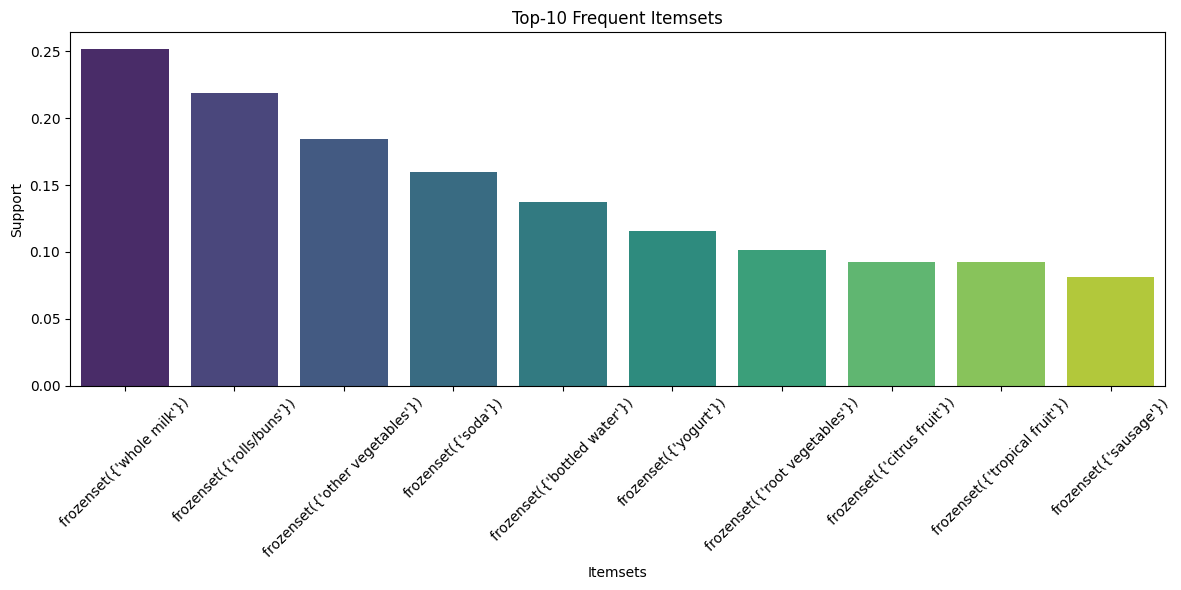

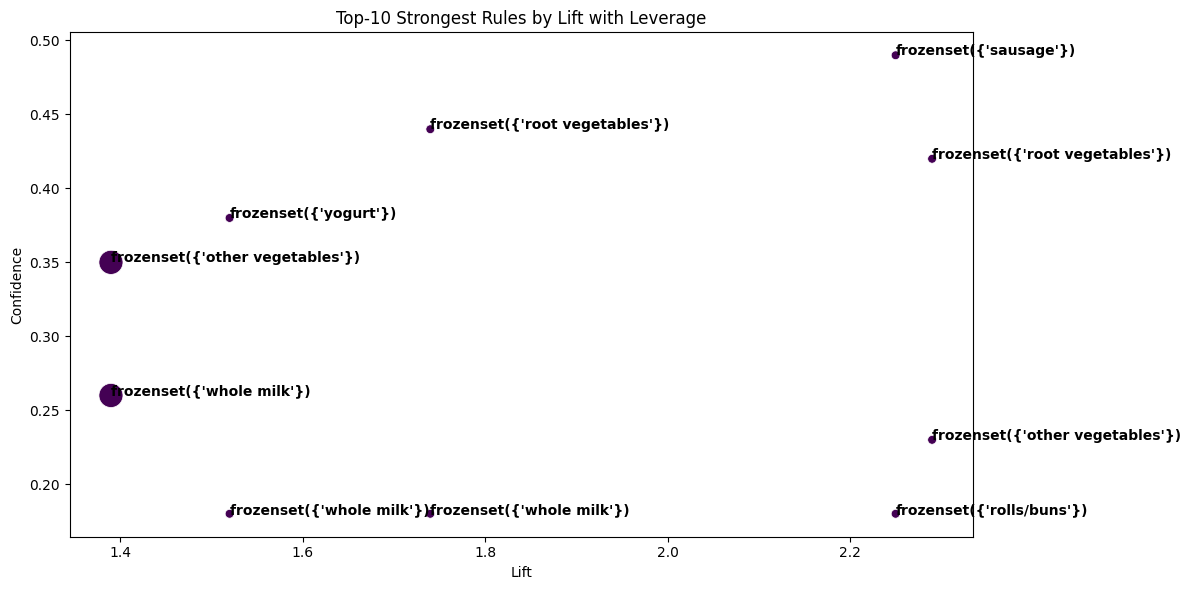

In [27]:
visualize(support_data, rule_list)